<a href="https://colab.research.google.com/github/ALABO117/colab/blob/main/%E3%80%8CDeepAnt_ipynb%E3%80%8D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Settings for Google Colab

Please uncomment and run cell below if your are on Colab to set data and auxiliary files.

In [2]:
# %%capture
!mkdir data
!wget https://raw.githubusercontent.com/datacubeR/DeepAnt/master/data/TravelTime_451.csv -O data/TravelTime_451.csv
!wget https://raw.githubusercontent.com/datacubeR/DeepAnt/master/data/DeepAnt.png -O data/DeepAnt.png
!wget https://raw.githubusercontent.com/datacubeR/DeepAnt/master/deepant.py -O deepant.py
!wget https://raw.githubusercontent.com/datacubeR/DeepAnt/master/utils.py -O utils.py
!pip install pytorch-lightning
!pip install torchinfo

--2024-01-04 11:23:42--  https://raw.githubusercontent.com/datacubeR/DeepAnt/master/data/TravelTime_451.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51918 (51K) [text/plain]
Saving to: ‘data/TravelTime_451.csv’

data/TravelTime_451 100%[===================>]  50.70K  --.-KB/s    in 0.006s  

2024-01-04 11:23:42 (7.84 MB/s) - ‘data/TravelTime_451.csv’ saved [51918/51918]

--2024-01-04 11:23:42--  https://raw.githubusercontent.com/datacubeR/DeepAnt/master/data/DeepAnt.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98003 

In [3]:
from google.colab import files #匯入套件
import pandas as pd
upload = files.upload() #開啟上傳介面並載入


Saving NoiseSymbol.csv to NoiseSymbol.csv


## DeepAnt

In [4]:
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from torchinfo import summary

from deepant import AnomalyDetector, DataModule, TrafficDataset, DeepAnt

from utils import plot_predictions, loss_plot, ts_plot

pl.seed_everything(42, workers=True)


if not torch.cuda.is_available():
    print('Please Activate GPU Accelerator if available')
else:
    print('Everything is Set')


INFO:lightning_fabric.utilities.seed:Seed set to 42


Everything is Set


## Data Import

In order to implement DeepAnt I will use a dataset that is part of Numenta Benchmark that is used in the Paper as part of Model Validation. The dataset can be found in the same Repo. According to the name, the dataset contains Traveltime as a timeseries.

The task is to find out what scores are anomaly.

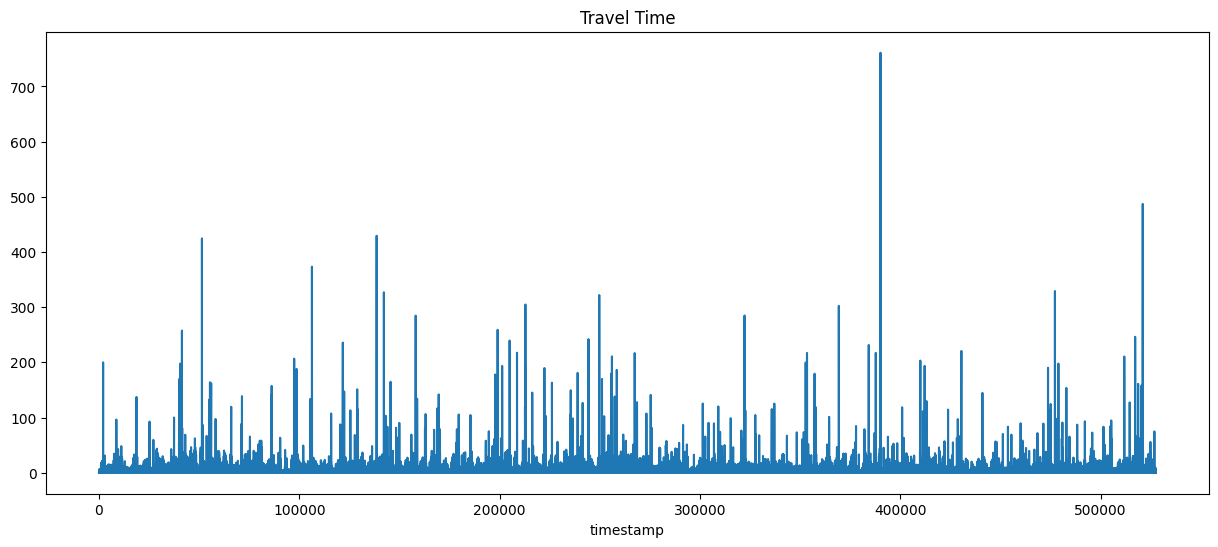

In [5]:
df = pd.read_csv('NoiseSymbol.csv', index_col = 'timestamp', parse_dates=['timestamp'])
df.plot(figsize = (15, 6), title = 'Travel Time', legend = False);

## Model Training

In order to make the algorithm to work I will use Hyperparameters mentioned in the paper as much as possible. In case no values are provided, I will be hard coding those.

![](https://github.com/datacubeR/DeepAnt/blob/master/data/DeepAnt.png?raw=1)

In this case, I will be using Sequence Length of 10, and Forecasting Horizon (P_w) 1. The Convolution Blocks use 32 filters, 3x3 Conv Kernel and 2x2 MaxPooling. Fully Connected Layer uses a 40 Units Hidden Layer before Ouptut.

The Model is Trained with MAE Loss (L1Loss in Pytorch) during 30 epochs.



In [6]:
SEQ_LEN = 10
dataset = TrafficDataset(df, SEQ_LEN)
target_idx = dataset.timestamp # Timestamps to detect where the Anomaly Happens
X, y = dataset[0]
X.shape, y.shape, len(dataset) # Checking Sizes are compatible...


(torch.Size([1, 10]), torch.Size([1]), 527490)

In [7]:
model = DeepAnt(SEQ_LEN, 1)
sample = torch.randn(32,1,10)

model(sample).shape

torch.Size([32, 1])

In [8]:
model = DeepAnt(SEQ_LEN, 1)
anomaly_detector = AnomalyDetector(model)
dm = DataModule(df, SEQ_LEN)
mc = ModelCheckpoint(
    dirpath = 'checkpoints',
    save_last = True,
    save_top_k = 1,
    verbose = True,
    monitor = 'train_loss',
    mode = 'min'
    )

mc.CHECKPOINT_NAME_LAST = f'DeepAnt-best-checkpoint'
summary(model)

Layer (type:depth-idx)                   Param #
DeepAnt                                  --
├─Sequential: 1-1                        --
│    └─Conv1d: 2-1                       128
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-4                       3,104
│    └─ReLU: 2-5                         --
│    └─MaxPool1d: 2-6                    --
├─Flatten: 1-3                           --
├─Sequential: 1-4                        --
│    └─Linear: 2-7                       1,320
│    └─ReLU: 2-8                         --
│    └─Dropout: 2-9                      --
├─Linear: 1-5                            41
Total params: 4,593
Trainable params: 4,593
Non-trainable params: 0

In [9]:
trainer = pl.Trainer(max_epochs=30,
                    accelerator="gpu",
                    devices=1,
                    callbacks=[mc],
                    #progress_bar_refresh_rate=30,
                    #fast_dev_run=True,
                    #overfit_batches=1
                    )
trainer.fit(anomaly_detector, dm)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type    | Params
--------------------------------------
0 | model     | DeepAnt | 4.6 K 
1 | criterion | L1Loss  | 0     
--------------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 16485: 'train_loss' reached 0.00392 (best 0.00392), saving model to '/content/checkpoints/epoch=0-step=16485.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 32970: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 49455: 'train_loss' reached 0.00232 (best 0.00232), saving model to '/content/checkpoints/epoch=2-step=49455.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 65940: 'train_loss' reached 0.00078 (best 0.00078), saving model to '/content/checkpoints/epoch=3-step=65940.ckpt' as top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 82425: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 98910: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 115395: 'train_loss' was not in top 1
INFO:pytorch_lightning.utilitie

In [10]:
anomaly_detector = AnomalyDetector.load_from_checkpoint('checkpoints/DeepAnt-best-checkpoint.ckpt',
                                model = model)

In [11]:
output = trainer.predict(anomaly_detector, dm)
preds_losses = pd.Series(torch.tensor([item[1] for item in output]).numpy(), index = target_idx)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Predicting: |          | 0/? [00:00<?, ?it/s]

# Finding Threshold

After checking the Loss Distribution, the Threshold chose for detecting anomaly wat set to 0.5

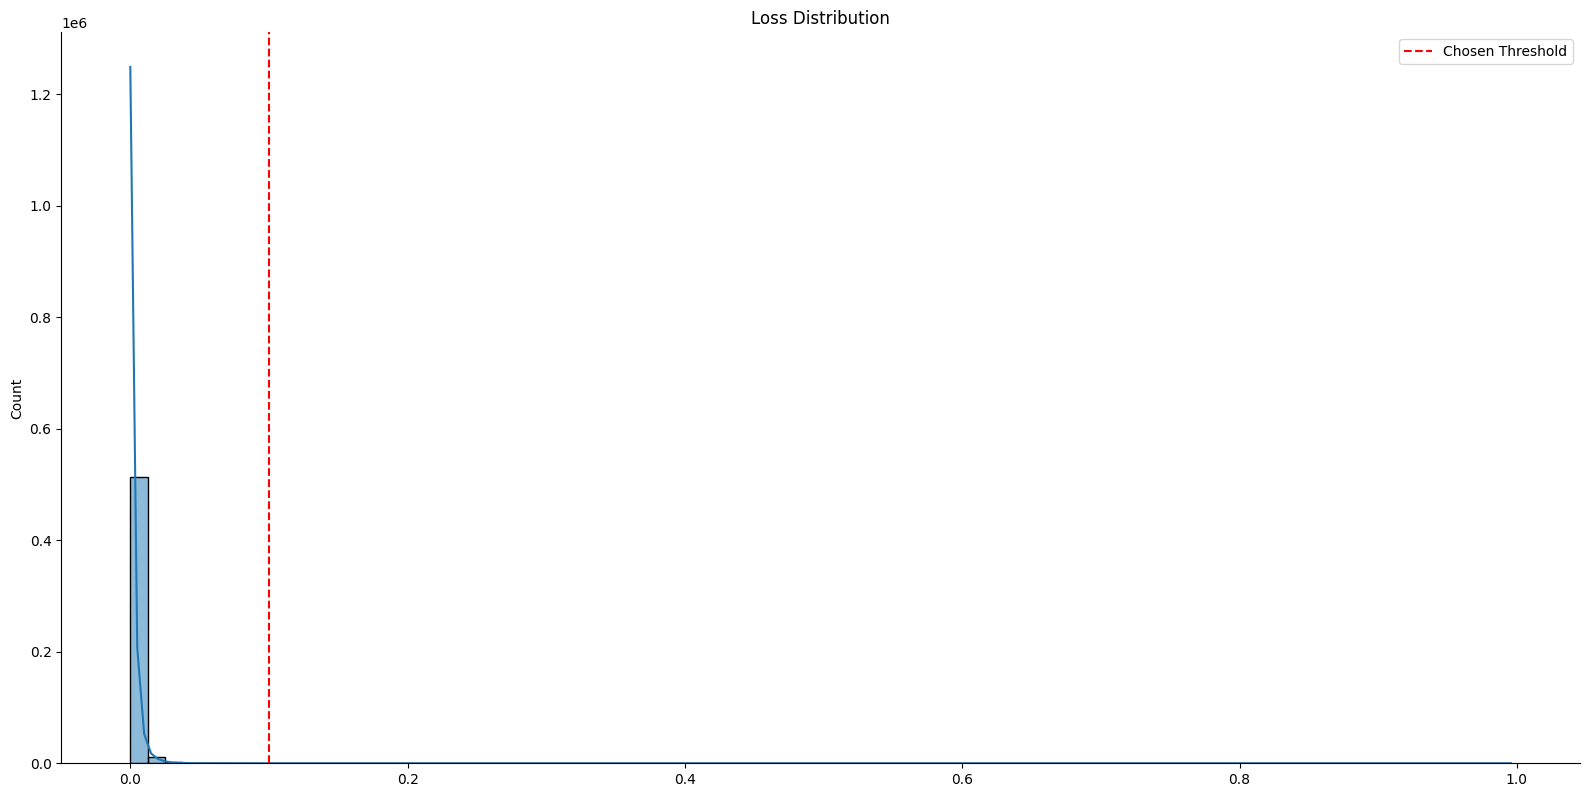

In [28]:
THRESHOLD = 0.1
plot_predictions(preds_losses, THRESHOLD)

## Detected Anomalies

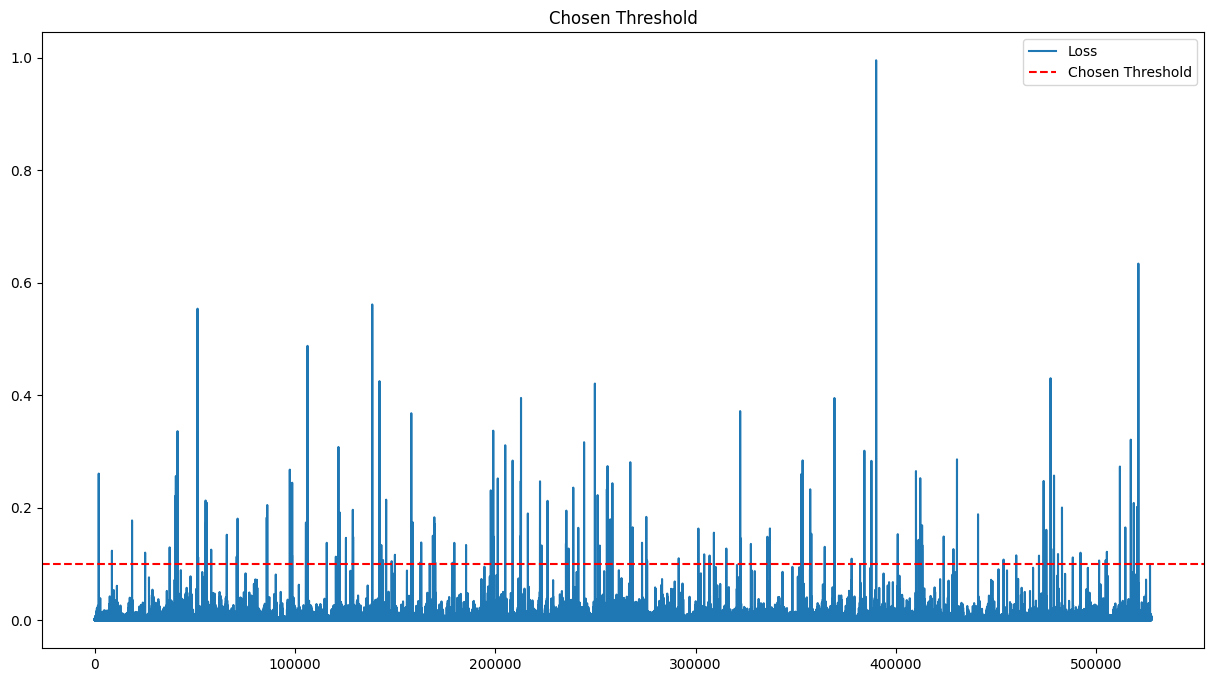

Anomalies Detected: 


2088      0.260826
8682      0.123727
18725     0.177525
25258     0.120261
37490     0.129664
            ...   
514491    0.165102
517220    0.321191
518709    0.208600
520375    0.201643
521002    0.634230
Length: 138, dtype: float32

In [29]:
loss_plot(preds_losses, THRESHOLD)

print('Anomalies Detected: ')
preds_losses.loc[lambda x: x > THRESHOLD]

## Showing Anomalies in Context

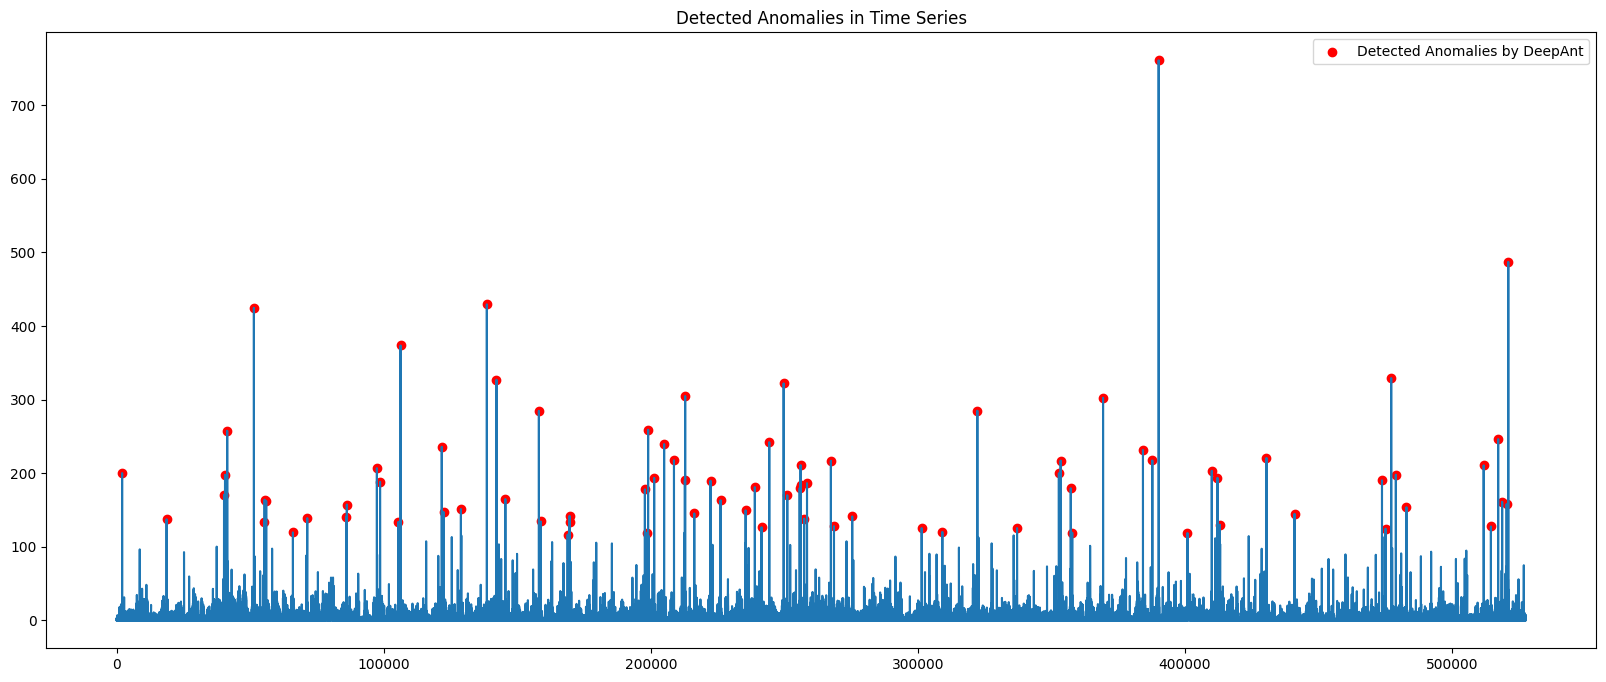

In [20]:
ts_plot(df, preds_losses, THRESHOLD)

## Looking Closer

In [ ]:
ts_plot(df, preds_losses, THRESHOLD, range = (int(range[0]), int(range[1])))

TypeError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
